# 14.4 자동 미분과 GradientTape로 그레이디언트 계산
* 그레이디언트 계산: 신경망의 최적화를 위한 신경망의 가중치에 대한 비용 계산
    * 확률적 경사 하강법과 같은 알고리즘 필요
    * 신경망 모델이 한 테스트 샘플에 대해 특정 예측을 만드는지에 대해 분석하는데 용이

### 14.4.1 훈련 가능한 변수에 대한 손실의 그레이디언트 계산
* 텐서플로의 자동 미분(automatic differentiation) 지원
    * 이를 위해 중첩된 함수의 그레이디언트를 계산하기 위해 연쇄 법칙을 구현한 것
    * 그레이디언트를 계산하려면 `tf.GradientTape`를 통해 기록

In [1]:
import tensorflow as tf
# 모델 파라미터 w, b
w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

# 입력 x, y를 텐서로 정의
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

# tf.GradientTape 컨텍스트 안에서 z와 손실 계산
with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw : ', dloss_dw)

True True
dL/dw :  -0.559999764


z를 계산할 때 '그레이디언트 테이프'에 기록되는 필요한 연산을 신경망의 정방향 계산으로 생각할 수 있다. 

In [2]:
# 계산된 그레이디언트 확인
tf.print(2 * x * (w * x + b- y))

[-0.559999764]


### 14.4.2 훈련하지 않는 변수에 대한 그레이디언트 계산
* `tf.GradientTape`는 훈련 가능한 변수를 위한 그레이디언트를 기본으로 지원.
    * 훈련하지 않는 변수와 다른 Tensor 객체일 경우 `tape.watch()`를 호출하여 이 변수도 추적하기 위해 GradientTape에 추가적으로 알려줘야 한다.

In [3]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.square(y - z)

dloss_dx = tape.gradient(loss, x)
tf.print('dL/dx:', dloss_dx)

dL/dx: [-0.399999857]


In [4]:
# 계산된 그레이디언트 검증
tf.print(2 * w * (w * x + b- y))

[-0.399999857]


### 14.4.3 여러 개의 그레이디언트 계산
* `tf.GradientTape` 컨텍스트에서 계산을 모니터링할 때 기본적으로 이 테이프는 하나의 그레이디언트 계산을 위한 자원만 유지한다.
    * `tape.gradient()`를 한 번 호출하고 나면 이 자원이 반납되고 테이프는 초기화된다.
    * 하나 이상의 그레이디언트를 계산하려면 persistent 매개변수를 True로 설정하여 테이프를 시작해야 한다.

In [5]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)

dL/dw: -0.559999764
dL/db: -0.399999857


한 개 이상의 그레이디언트를 계산하고 싶을 때만 사용해야 한다. 이런 그레이디언트 테이프를 기록하고 유지하는 것은 하나의 그레이디언트를 계산한 후 메모리를 반납하는 것에 비해 메모리 비효율적이다. 이런 이유로 `persistent=False`가 기본값이다.

모델 파라미터에 대한 손실의 그레이디언트를 계산하고 있다면 옵티마이저를 정의하고 tf.keras.API를 사용해서 이 그레이디언트를 적용해 모텔 파라미터를 최적화할 수 있다.

In [6]:
optimizer = tf.keras.optimizers.SGD()
optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

tf.print('업데이트된 w:', w)
tf.print('업데이트된 b:', b)

업데이트된 w: 1.0056
업데이트된 b: 0.504


초기 가중치와 절편은 w=1.0과 b=0.5였다. 모델 파라미터에 대한 손실의 그레이디언트를 적용하여 모델 파라미터가 w=1.0056, b=0.504로 바뀌었다.

# 14.5 케라스 API를 사용하여 일반적인 구조 구현하기


In [7]:
# 두 개의 밀집(완전) 연결 층으로 구성된 모델
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

# 변수 지연 생성
model.build(input_shape=(None, 4)) # 입력 크기를 지정하여 모델을 정의한 후 특정 크기의 변수 초기화
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


각 층의 파라미터 개수가 출력되었다. 첫 번째 층은 16 * 4 + 16 = 80개이고, 두 번째 층은 16 * 32 + 32 = 544 개이다. 변수(또는 모델 파라미터)가 만들어지면 훈련하는 파라미터와 훈련하지 않는 파라미터를 모두 참조할 수 있다.

In [8]:
# 모델 변수 출력하기
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


각 층은 가중치 행렬 kernel과 절편 벡터 bias를 가진다.

#### 활성화 함수, 변수 초기화 또는 파라미터 규제
* 활성화 함수 선택
    * tf.keras.activations
    * https://www.tensorflow.org/api_docs/python/tf/keras/activations
* 층의 파라미터 초기화
    * tf.keras.initializers
    * https://www.tensorflow.org/api_docs/python/tf/keras/initializers
* 층의 파라미터에 규제 적용
    * tf.keras.regularizers
    * 과대적합 막기
    * https://www.tensorflow.org/api_docs/python/tf/keras/regularizers

In [9]:
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Dense(
        units=16,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.glorot_uniform(), # 첫 번째 층에 커널과 절편 변수 초기화 지정
        bias_initializer=tf.keras.initializers.Constant(2.0)
    ))
model.add(
    tf.keras.layers.Dense(
        units=32,
        activation=tf.keras.activations.sigmoid, # 두 번째 층에 커널(가중치 행렬)과 L1 규제 지정
        kernel_regularizer=tf.keras.regularizers.l1
    )
)
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


개별 층의 설정뿐만 아니라 컴파일할 때 모델의 설정도 바꿀 수 있다. 옵티마이저의 타입과 훈련에 사용할 손실 함수를 지정할 수 있다. 훈련, 검증 테스트 데이터셋에 대한 성능 리포팅에 사용할 지표를 지정할 수도 있다.

* 옵티마이저
    * tf.keras.optimizers
    * https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
* 손실 함수
    * tf.keras.losses
    * https://www.tensorflow.org/api_docs/python/tf/keras/losses
    * `SGD`와 `Adam`이 가장 널리 사용되는 방법이다.
* 성능 지표
    * tf.keras.metrics
    * https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    * 정밀도, 재현율, 정확도, AUC, 거짓 음성과 거짓 양성 점수는 분류 모델을 평가하는 데 적절한 지표이다.

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), # SGD 옵티마이저
    loss=tf.keras.losses.BinaryCrossentropy(), # 이진 분류를 위한 크로스 엔트로피 손실함수
    metrics=[tf.keras.metrics.Accuracy(), # 정확도
             tf.keras.metrics.Precision(), # 정밀도
             tf.keras.metrics.Recall(),] # 재현율
)

* complie() 메서드
    * 옵티마이저로 SGD 클래스의 기본값을 사용할 때는 optimizer='sgd'와 같이 클래스 이름을 소문자 문자열로 쓸 수 있다.
        * tf.keras.optimizers 아래에 있는 다른 옵티마이저도 마찬가지.
    * loss 매개변수와 metrics 매개변수에는 자주 사용하는 클래스를 문자열로 쓸 수 있다.
        * loss 매개변수
            * 이진 크로스 엔트로피: 'binary_crossentropy'
            * 범주형 크로스 엔트로피: 'categorical_crossentropy'
            * 평균 제곱 오차: 'mse'
            * 평균 절대값 오차: 'mae'
        * metrics 매개변수
            * 정확도: 'accuracy'
            * 평균 제곱 오차: 'mse'
            * 평균 절대값 오차: 'mae'

### 14.5.1 XOR 분류 문제
* 두 개의 클래스 사이에서 비선형 결정 경계를 감지하는 모델의 수용 능력을 분석하기 위한 문제
* 먼저 [-1, 1) 사이의 균등 분포에서 뽑은 두 개의 특성 ($x_{0}, x_{1}$)을 가진 200개의 훈련 샘플이 들어 있는 작은 데이터셋을 생성한 후, 규칙에 따라 훈련 샘플 i에 정답 레이블 부여
    * y = 0 if x0 * x1 < 0 else 1 

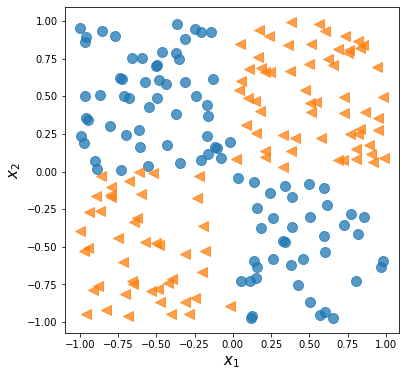

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

# 절반의 데이터(100개의 훈련 샘플)는 훈련에 사용하고 남은 절반은 검증에 사용
x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

층이 많을수록 각 층에 뉴런 개수가 많을수록 모델의 수용 능력이 크다. 모델의 수용 능력은 모델이 얼마나 복잡한 함수를 근사할 수 있는지를 측정한 것이다. 많은 파라미터를 가지고 있으면 모델이 복잡한 함수를 근사할 수 있지만 모델이 클수록 훈련하기 힘들다(또한 과대적한되기 쉽다). 실제로는 로지스틱 회귀, 즉 간단한 단일층 신경망처럼 간단한 기본 모델로 시작하는 것이 좋다.

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                                input_shape=(2,),
                                activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


로지스틱 회귀 모델의 전체 파라미터 크기는 3이다. 가중치 행렬(또는 커널)의 크기가 2 * 1이고 절편 벡터의 크기는 1이다.

In [13]:
# 컴파일하고 배치 크기 2로 200 에포크동안 훈련
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [14]:
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

model_fit() 메서드는 훈련 에포크의 기록을 반환한다. 훈련한 후 이를 시각화하여 분석하기 좋다.

In [15]:
!pip install --upgrade mlxtend

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


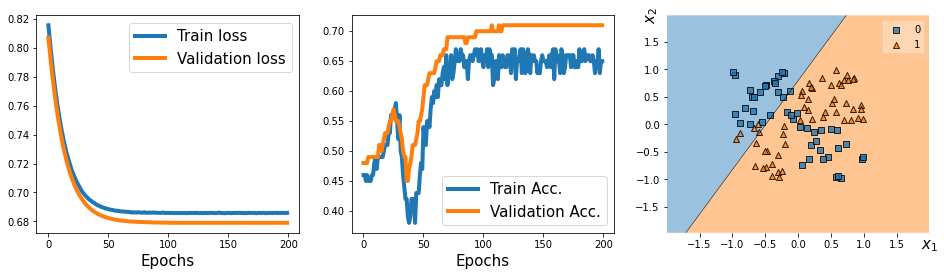

In [16]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

위 결과에서 볼 수 있듯이 은닉층이 없는 간단한 모델은 선형 결정 경계만 찾을 수 있다. 따라서 XOR 문제를 풀 수 없다.

비선형 결정 경계를 찾기 위해서는 비선형 활성화 함수를 사용한 한 개 이상의 은닉층을 추가해야한다. 일반 근사 이론에 의하면 하나의 은닉층과 매우 많은 은닉 유닛을 가진 피드포워드 신경망은 임의의 연속 함수를 비교적 잘 근사할 수 있다. 따라서 XOR 문제를 좀 더 만족스럽게 해결하는 방법은 은닉층을 추가하고 검증 데이터셋에서 만족스로운 결과가 나올 때까지 **은닉 유닛 개수를 바꾸**면서 비교해봐야 한다. **은닉 유닛을 늘린다는 것은 층의 폭을 넓히는 것**과 같다. 또는 더 많은 **은닉층을 추가하여 모델의 깊이를 깊게** 할 수도 있다. 네트워크의 폭 대신 **깊이를 깊게 하면 비슷한 모델 수용 능력을 달성하는 데 필요한 파라미터 개수가 적다는 장점**이 있지만, (넓은 모델에 비해) **깊은 모델은 그레이디언트가 폭주하거나 소멸될 수 있어 훈련하기 어려운 단점**이 있다.

In [17]:
# 세 개의 은닉층으로 구성된 피드포워드 신경망
tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# 훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)
history = hist.history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  app.launch_new_instance()


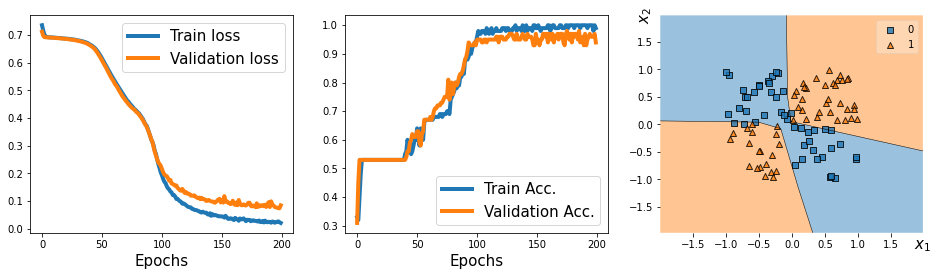

In [19]:
# 시각화
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

모델이 이 데이터에서 비선형 결정 경계를 찾은 것을 볼 수 있다. 이 모델은 훈련 데이터셋에서 100% 정확도를 달성했다. 검증 데이터셋의 정확도는 95%로 모델이 약간 과대적합된 것으로 보인다.

### 14.5.2 케라스 함수형 API로 유연성이 높은 모델 만들기

* 케라스 Sequential 클래스
    * 객체 지향 방식
    * 모델을 만드는 간편하고 일반적인 방법
    * 여러 개의 입력이나 출력을 가지거나 중간 가지(branch)가 있는 복잡한 모델을 만들 수 없다. => 케라스 함수형 API가 필요한 이유

In [20]:
tf.random.set_seed(1)

# 먼저 입력 지정
inputs = tf.keras.Input(shape=(2,))

# 은닉층 - 은닉층의 출력은 각각 h1, h2, h3
# 각 층의 출력을 이어지는 층의 입력으로 사용
h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)

# h3을 입력으로 받는 마지막 밀집층의 출력을 저장
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)

# 모델
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


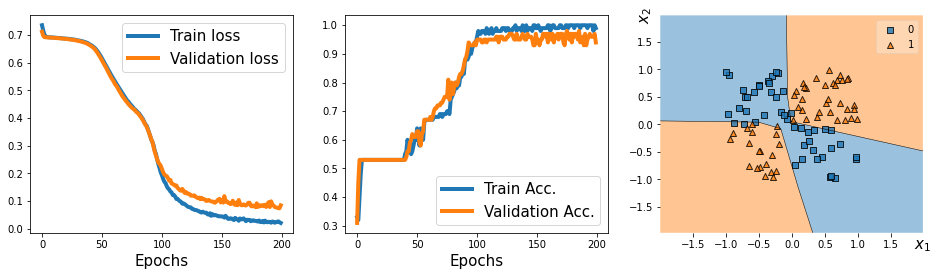

In [21]:
# 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# 훈련
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

# 시각화
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 14.5.3 케라스의 Model 클래스 기반으로 모델 만들기

* tf.keras.Model 클래스 상속
    * 생성자 `__init__()` 메서드 정의
        * self 변수를 통해 참조할 수 있도록 클래스 속성으로 층을 정의
    * call() 메서드: 정방향 계산 정의

In [22]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
    
    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

tf.random.set_seed(1)

model = MyModel()
model.build(input_shape=(None, 2))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            multiple                  12        
                                                                 
 dense_14 (Dense)            multiple                  20        
                                                                 
 dense_15 (Dense)            multiple                  20        
                                                                 
 dense_16 (Dense)            multiple                  5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


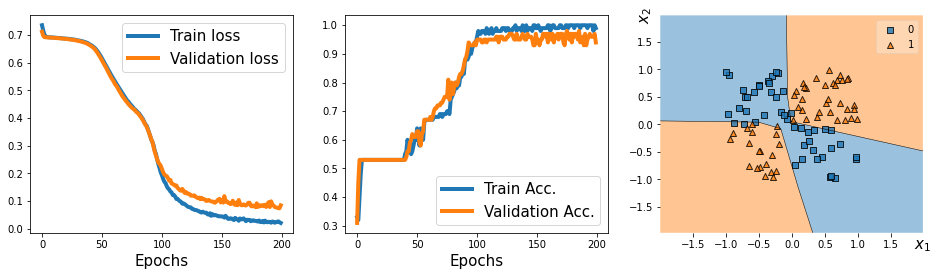

In [23]:
# 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# 훈련
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

# 시각화
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

텐서플로 2.2부터는 tf.keras.Model 클래스를 상속한 경우 train_step() 메서드에서 tf.GradientTape 컨텍스트로 훈련 단계를 세밀하게 조정할 수 있다.

In [24]:
class MyCustomStepModel(MyModel):
    def train_step(self, data):
        # fit()에서 전달된 데이터
        x, y = data
        
        # 그레이디언트 기록 시작
        with tf.GradientTape() as tape:
            # 정방향 계산
            y_pred = self(x) # Model 객체의 __call__() 메서드 실행 - __call__() 메서드의 핵심 역할은 call() 메서드를 호출하는 것
            # compile() 메서드에서 지정한 손실 계산 - compiled_loss()
            # compiled_loss()는 compile() 메서드에서 지정한 손실을 자동으로 계산해준다.
            # regularization_losses 매개변수에 각 층의 규제 손실을 담은 self.losses를 전달하면
            # 케라스 층의 kernel_regularizer에서 지정한 규제가 자동으로 손실에 반영된다.
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        
        # 훈련 가능한 파라미터에 대한 그레이디언트 계산 - gradient() 메서드
        gradients = tape.gradient(loss, self.trainable_variables)
        # 파라미터 업데이트 - apply_gradients()
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # TF 2.4일 경우, self.optimizer.minimize(loss, self.trainable_variables, tape=tape)

        # compile() 메서드에서 지정한 지표를 업데이트하기 위해 타깃과 예측 값으로
        # compiled_metrics.update_state() 호출한다.
        self.compiled_metrics.update_state(y, y_pred)

        # 현재까지 지표와 결과값을 딕셔너리로 반환
        return {m.name: m.result() for m in self.metrics} 

In [25]:
tf.random.set_seed(1)

## 테스트
model = MyCustomStepModel()
model.build(input_shape=(None, 2))

model.summary()

Model: "my_custom_step_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            multiple                  12        
                                                                 
 dense_18 (Dense)            multiple                  20        
                                                                 
 dense_19 (Dense)            multiple                  20        
                                                                 
 dense_20 (Dense)            multiple                  5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


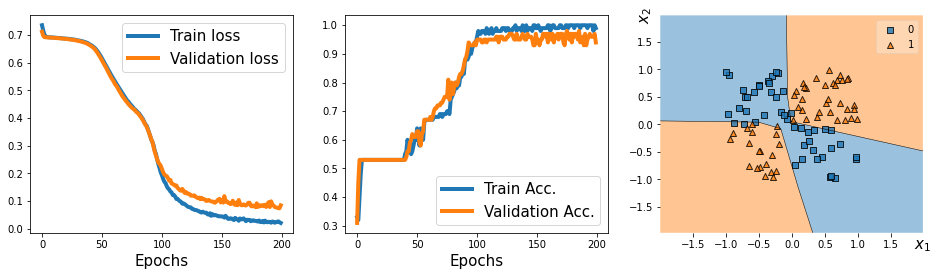

In [26]:
# 컴파일
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 훈련
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

# 시각화
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=4)
plt.plot(history['val_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 14.5.4 사용자 정의 케라스 층 만들기

* tf.keras.layers.Layer 클래스 상속
    * 케라스에서 제공하지 않는 층을 새로 정의해야 하는 경우 사용
    * 새로운 층을 만들거나 기존 층을 커스터마이징할 때 특히 유용

In [27]:
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev # 표준 편차 지정
        super(NoisyLinear, self).__init__(**kwargs)
    
    # input_shape 매개변수가 있으면 변수를 만들고 초기화할 수 있다.
    def build(self, input_shape): # 변수 생성을 지연하고 build() 메서드에 변수 생성을 위임할 수 있다.
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer='zeros',
                                 trainable=True)
    
    # training: 어떤 모델이나 층이 훈련(ex, fit())에 사용되는지 또는 예측(ex, predict())에 사용되는지 구분하기 위한 특별한 매개변수
    # 훈련과 예측 간의 차이점은 예측에서는 그레이디언트가 필요하지 않다는 것.
    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)
            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs 
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)
    
    # 직렬화를 위한 get_config() 메서드
    # 이 사용자 정의 층으로 만든 모델을 텐서플로의 모델 저장과 복원 기능을 사용하여 효율적으로 저장하기 위해서이다.
    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev}) 
        return config

tf.random.set_seed(1)

noisy_layer = NoisyLinear(4) # 객체 생성
noisy_layer.build(input_shape=(None, 4)) # 초기화

x = tf.zeros(shape=(1, 4)) # 입력 텐서
tf.print(noisy_layer(x, training=True))

# 설정을 사용해 모델 만들기
config = noisy_layer.get_config() # 직렬화
new_layer = NoisyLinear.from_config(config) # from_config() 메서드를 사용하여 직렬화된 객체 복원
tf.print(new_layer(x, training=True))

[[0 0.00821428 0 0]]
[[0 0.0108502861 0 0]]


In [28]:
# XOR 분류 문제를 풀기 위한 모델
# Sequential 클래스를 사용하지만 NoisyLinear 층을 다층 퍼셉트론의 첫 번째 은닉층으로 사용
tf.random.set_seed(1)

model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])
model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noisy_linear_1 (NoisyLinear  (None, 4)                12        
 )                                                               
                                                                 
 dense_21 (Dense)            (None, 4)                 20        
                                                                 
 dense_22 (Dense)            (None, 4)                 20        
                                                                 
 dense_23 (Dense)            (None, 1)                 5         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


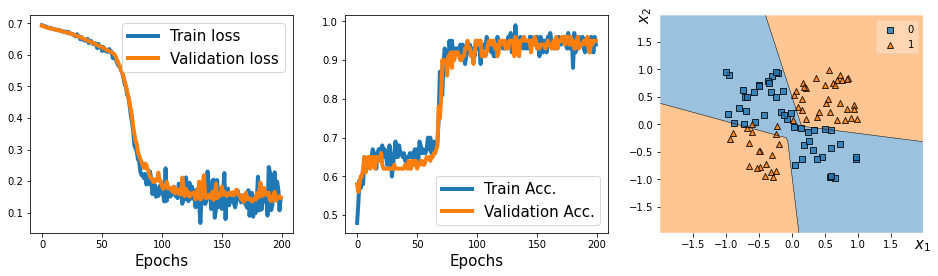

In [29]:
# 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# 훈련
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, 
                 verbose=0)

# 시각화
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
# plt.savefig('images/14_4.png', dpi=300)
plt.show()